In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import datetime
from IPython.display import clear_output
from datetime import timedelta
from scipy.stats import skewnorm
import inspect, re
import h2o
from h2o.automl import H2OAutoML
import xgboost as xgb
import random
import gc
from sklearn.model_selection import train_test_split
from sklearn import  metrics
import time
import progressbar
import warnings
import math
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV as LogReg
from scipy import signal
               
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from WOE_Houston import *

In [2]:
fy_10 = pd.read_csv('2010_council.csv')
fy_11 = pd.read_csv('2011_council.csv')
fy_12 = pd.read_csv('2012_council.csv')
fy_13 = pd.read_csv('2013_council.csv')
fy_14 = pd.read_csv('2014_council.csv')
fy_15 = pd.read_csv('2015_council.csv')
fy_16 = pd.read_csv('2016_council.csv')

fy_list = [fy_10, fy_11, fy_12, fy_13, fy_14, fy_15, fy_16]

del fy_10
del fy_11
del fy_12
del fy_13
del fy_14
del fy_15
del fy_16
gc.collect()

essentials = ['Unnamed: 0',
 'Fund Id',
 'Business Area',
 'Fund Center Id',
 'GL Account',
 'GL Description',
 'GL Category',
 'GL Category Description',
 'Revenue or Expenditure',
 'Fiscal Year',
 'Fund Name',
 'Fund Type Descr',
 'Business Area Name',
 'Fund Center Name',
 'Commitment Set Description',
 'Original Budget',
 'Current Budget',
 'Actuals',
 '3Y_Past_Actuals',
 '2Y_Past_Actuals',
 '1Y_Past_Actuals',
 '2Y_1Y_Actuals_Mean',
 '3Y_2Y_1Y_Actuals_Mean',
 '3Y_Past_Original_Budget',
 '2Y_Past_Original_Budget',
 '1Y_Past_Original_Budget',
 '2Y_1Y_Original_Budget_Mean',
 '3Y_2Y_1Y_Original_Budget_Mean',
 '3Y_Past_OA_Difference',
 '2Y_Past_OA_Difference',
 '1Y_Past_OA_Difference',
 '2Y_1Y_OA_Difference_Mean',
 '3Y_2Y_1Y_OA_Difference_Mean',
 'OA_Difference',
 'Yearly Crime Index',
 'Yearly Avg High Temp',
 'Yearly Avg Low Temp',
 'Yearly Rain Fall',
 'Astros Playoff Rounds',
 'Astros Yearly Attendance',
 'Rockets Playoff Rounds',
 'Texans Playoff Rounds',
 'Texans Average Attendance',
 'Rockets Total Attendance']

dummies = ['Fund Name_Asset Forfeiture Fund - Justice',
 'Fund Name_Asset Forfeiture Fund - State',
 'Fund Name_Auto Dealers Fund',
 'Fund Name_Building Inspection Fund',
 'Fund Name_C&E-Civic Center Facility Revenue Fund',
 'Fund Name_Cable Television Fund',
 'Fund Name_Child Safety Fund',
 'Fund Name_Digital Houston Special Revenue',
 'Fund Name_Expansion of Recycling Program',
 'Fund Name_Fleet Management Fund',
 'Fund Name_GSD - In-House Renovation Revolving Fund',
 'Fund Name_General Fund',
 'Fund Name_Greater Houston Trans & Emer Center',
 'Fund Name_HAS-Revenue Fund',
 'Fund Name_Health Benefits Fund',
 'Fund Name_Historic Preservation Fund',
 'Fund Name_Houston Emergeny Center',
 'Fund Name_Long-Term Disablility Plan Fund',
 'Fund Name_Municipal Court Technology Fund',
 'Fund Name_PWE-Combined Utility System Gen Pur Fund',
 'Fund Name_PWE-Combined Utility System Oper Fund',
 'Fund Name_PWE-W & S System Operating Fund',
 'Fund Name_Park Special Revenue Fund',
 'Fund Name_Parking Mangement Operating Fund',
 'Fund Name_Police Special Services',
 'Fund Name_Project Cost Recovery',
 'Fund Name_Property & Casualty Fund',
 'Fund Name_Stormwater Fund',
 'Fund Name_Supplemental Environmental Proj',
 'Fund Name_Workers Compensation Admin Fund',
 'Fund Type Descr_Enterprise Funds',
 'Fund Type Descr_General Funds',
 'Fund Type Descr_Internal Services Funds',
 'Fund Type Descr_Special Revenue Funds',
 'Business Area Name_Admn. & Regulatory Affairs',
 'Business Area Name_Business Opportunity',
 "Business Area Name_City Controller's Office",
 'Business Area Name_City Council',
 'Business Area Name_City Secretary',
 'Business Area Name_Citywide General Government',
 'Business Area Name_Convention and Entertainment',
 'Business Area Name_Finance',
 'Business Area Name_General Debt Services',
 'Business Area Name_General Services Department',
 'Business Area Name_Health & Human Services',
 'Business Area Name_Housing and Community Devp.',
 'Business Area Name_Houston Airport System (HAS)',
 'Business Area Name_Houston Emergency Center (HEC)',
 'Business Area Name_Houston Fire Department (HFD)',
 'Business Area Name_Houston Police Department',
 'Business Area Name_Human Resources Dept.',
 'Business Area Name_Information Technology (IT)',
 'Business Area Name_Legal Department',
 'Business Area Name_Library',
 "Business Area Name_Mayor's Office",
 'Business Area Name_Municipal Court Judicial',
 'Business Area Name_Municipal Courts Department',
 'Business Area Name_Parks & Recreation',
 'Business Area Name_Planning & Development',
 'Business Area Name_Public Works & Engineering-PWE',
 'Business Area Name_Solid Waste Management',
 'Commitment Set Description_50 - Total Expenditures',
 'Business Area Name_Houston Police Department-HPD',
 'Business Area Name_Houston Information Tech Svcs'
]

drop_list = [
    
    'Fund Name', 
    'Fund Type Descr', 
    'Business Area Name',
    'Commitment Set Description',
    'GL Description',
    'GL Category Description',
    'Revenue or Expenditure',
    'Fund Type Descr',
    'Fund Center Name'
]

       
        

        

In [3]:
splits_to_try = [
    
                #predicting off "two years"
                 [(0,1),(1,2),'10-11 to predict 11'],
                 [(0,2),(2,3),'10-11 to predict 12'],
                 [(0,3),(3,4),'10-12 to predict 13'],
                 #[(0,3),(3,5),'10-12 to predict 13 and 14'],
                 #[(2,4),(4,5),'12-13 to predict 14'],
                 [(1,4),(4,5),'11-13 to predict 14'], 
                 #[(1,4),(4,6),'11-13 to predict 14 and 15'],
                 #[(3,5),(5,6),'13-14 to predict 15'],
                 [(2,5),(5,6),'12-14 to predict 15'],
                 #[(2,5),(5,7),'12-14 to predict 15 and 16'],
                 #[(4,6),(6,7),'14-15 to predict 16'],
                 [(3,6),(6,7),'13-15 to predict 16'], 
    
                #predicting off "three" years
    
                 #[(0,4),(5,6),'10-13 to predict 14'],
                 #[(0,4),(4,6),'10-13 to predict 14 and 15'],
                 #[(0,4),(4,7),'10-13 to predict 14 and 15 and 16'],
                 #[(1,5),(5,6),'11-14 to predict 15'],
                 #[(1,5),(5,7),'11-14 to predict 15 and 16'],
                 #[(2,6),(6,7),'12-15 to predict 16']
                ]

In [4]:
train_iv_list = []
for i, y in enumerate(fy_list):
    train_iv, train_IV_series = data_vars(fy_list[i].drop(['OA_Difference','Actuals','Over Budget','Current Budget'], axis=1),  fy_list[i]['Over Budget'])
    train_iv_list.append([train_iv, train_IV_series])
    
keep_vars = []
for i, item in enumerate(train_iv_list):
    year_keep = list(train_iv_list[i][1].sort_values(ascending=False, by='IV').loc[train_iv_list[i][1]['IV']>=.003]['VAR_NAME'])
    if i==0:
        keep_vars = year_keep
        #print(len(year_keep))
    else:
        keep_vars = list(set(year_keep) | set(keep_vars))
        #print(len(year_keep))
        

drop_vars = set(set(list(fy_list[0].columns)).symmetric_difference(keep_vars))
print(len(drop_vars), len(keep_vars))

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:83: RuntimeWarning: divide by zero encountered in log
  d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:84: RuntimeWarning: divide by zero encountered in log
  d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:83: RuntimeWarning: divide by zero encountered in log
  d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:84: RuntimeWarning: divide by zero encountered in log
  d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:83: RuntimeWarning: divide by zero encountered in log
  d3["WO

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:84: RuntimeWarning: divide by zero encountered in log
  d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:83: RuntimeWarning: divide by zero encountered in log
  d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:84: RuntimeWarning: divide by zero encountered in log
  d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)


101 64


In [5]:
woe_pca_df_list = []
woe_pca_explained_var_ratio_list = []

for i, y in enumerate(fy_list):
    woe = WoeEncoder(columns=keep_vars, suffix='')
    target = 'Over Budget'
    y = fy_list[i][target]
    
    hold_df = woe.fit_transform(fy_list[i].drop(['OA_Difference','Actuals','Over Budget','Current Budget'], axis=1), y)
    
    pca = PCA(n_components=50)
    
    X = hold_df[keep_vars].fillna(0)
    del hold_df; gc.collect()
    
    pca.fit(X)
    
    woe_pca_df_list.append(pca.transform(X))
    woe_pca_explained_var_ratio_list.append(pca.explained_variance_ratio_.sum())

woe_pca_explained_var_ratio_list

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:83: RuntimeWarning: divide by zero encountered in log
  d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:84: RuntimeWarning: divide by zero encountered in log
  d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:83: RuntimeWarning: divide by zero encountered in log
  d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:84: RuntimeWarning: divide by zero encountered in log
  d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:83: RuntimeWarning: divide by zero encountered in log
  d3["WO

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:83: RuntimeWarning: divide by zero encountered in log
  d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:84: RuntimeWarning: divide by zero encountered in log
  d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:83: RuntimeWarning: divide by zero encountered in log
  d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:84: RuntimeWarning: di

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()
/Users/josephdown/Documents/Data Science/Data-Projects/Houston Open Data/WOE_Houston.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default = self.iv_df[s

[1.0000000000000002,
 0.9999999999999991,
 0.9999964523973596,
 0.99999613836085,
 0.9999906160837916,
 0.9999989582608306,
 0.9999957679130292]

In [20]:
splits_to_try[0][1][0]

1

In [27]:
for x in [splits_to_try[0]]:
    print(x)

[(0, 1), (1, 2), '10-11 to predict 11']


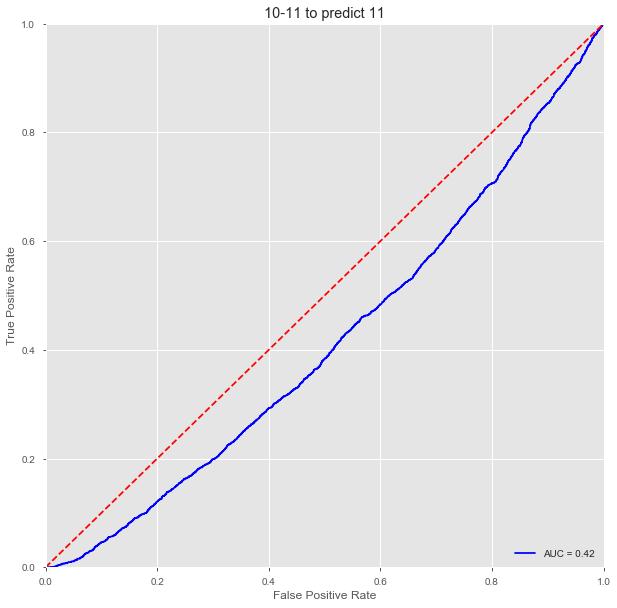

In [90]:

hold_list = []
fy_augmented = []
for index, split in enumerate([splits_to_try[0]]):
    
    hold_dict = {}
    
    X_train = pd.concat([pd.DataFrame(x) for x in woe_pca_df_list[split[0][0]:split[0][1]]])
    y_train = pd.concat([x['Over Budget'] for x in fy_list[int(split[0][0]):int(split[0][1])]])
    #X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)
    X_test = pd.concat([pd.DataFrame(x) for x in woe_pca_df_list[split[1][0]:split[1][1]]])
    y_test = pd.concat(x['Over Budget'] for x in fy_list[split[1][0]:split[1][1]])
    y_original_budget = pd.concat(x['Original Budget'] for x in fy_list[split[1][0]:split[1][1]])
    #X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

    model = xgb.XGBClassifier() #subsample= 0.8, min_child_weight= 1, max_depth= 4, gamma= 1, colsample_bytree= 1.0)
    model.fit(X_train,y_train)

    xgb_test_predictions = model.predict(X_test)
    xgb_train_predictions = model.predict(X_train)
    
    xgb_test_predictions_probability = [x[1] for x in model.predict_proba(X_test)]
    xgb_train_predictions_probability = [x[1] for x in model.predict_proba(X_train)]

    model_test_auc = metrics.roc_auc_score(y_test, xgb_test_predictions)
    model_train_auc = metrics.roc_auc_score(y_train, xgb_train_predictions)
    original_budget_auc = metrics.roc_auc_score(y_test, y_original_budget)
    
    if index <= 5:
        #hold_df = pd.concat([X_test, y_test]) #grab the test dataframe
        hold_df = pd.concat([x for x in fy_list[split[1][0]:split[1][1]]])
        hold_df['Over_Budget_Prediction'] = xgb_test_predictions_probability #add in the over under budget predictions
        fy_augmented.append(hold_df) #store it back in the woe_pca_df_list
    
    
    hold_dict.update({'split': split[2]})
    hold_dict.update({'model_test_auc': model_test_auc})
    hold_dict.update({'model_train_auc': model_train_auc})
    hold_dict.update({'original_budget_auc': original_budget_auc})
    hold_dict.update({'model':model})
    
    
    
    hold_list.append(hold_dict)
    
fpr, tpr, threshold = metrics.roc_curve(y_test, xgb_test_predictions_probability)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.title(split[2])
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
    

In [91]:
pd.DataFrame(hold_list).drop(['model'],axis=1)

,model_test_auc,model_train_auc,original_budget_auc,split
0,0.453356,0.704859,0.465611,10-11 to predict 11


In [92]:
confusion_df = pd.DataFrame(metrics.confusion_matrix(y_test, xgb_test_predictions))
confusion_df.columns=["", ""]
confusion_df.index =["",""]
confusion_df

,,
,5452,2058
,3268,721


In [93]:
confusion_matrix_key = confusion_df
confusion_matrix_key.iloc[0,0] = 'True Negatives'
confusion_matrix_key.iloc[1,0] = 'False Negative'
confusion_matrix_key.iloc[1,1] = 'True Positives'
confusion_matrix_key.iloc[0,1] = 'False Positives'
confusion_matrix_key.columns= ["",""]
confusion_matrix_key.index =["",""]
confusion_matrix_key


,,
,True Negatives,False Positives
,False Negative,True Positives


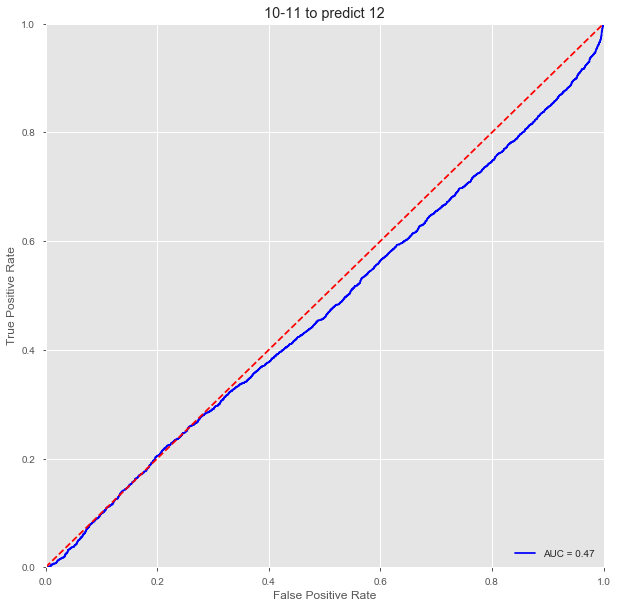

In [94]:

hold_list = []
fy_augmented = []
for index, split in enumerate([splits_to_try[1]]):
    
    hold_dict = {}
    
    X_train = pd.concat([pd.DataFrame(x) for x in woe_pca_df_list[split[0][0]:split[0][1]]])
    y_train = pd.concat([x['Over Budget'] for x in fy_list[int(split[0][0]):int(split[0][1])]])
    #X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)
    X_test = pd.concat([pd.DataFrame(x) for x in woe_pca_df_list[split[1][0]:split[1][1]]])
    y_test = pd.concat(x['Over Budget'] for x in fy_list[split[1][0]:split[1][1]])
    y_original_budget = pd.concat(x['Original Budget'] for x in fy_list[split[1][0]:split[1][1]])
    #X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

    model = xgb.XGBClassifier() #subsample= 0.8, min_child_weight= 1, max_depth= 4, gamma= 1, colsample_bytree= 1.0)
    model.fit(X_train,y_train)

    xgb_test_predictions = model.predict(X_test)
    xgb_train_predictions = model.predict(X_train)
    
    xgb_test_predictions_probability = [x[1] for x in model.predict_proba(X_test)]
    xgb_train_predictions_probability = [x[1] for x in model.predict_proba(X_train)]

    model_test_auc = metrics.roc_auc_score(y_test, xgb_test_predictions)
    model_train_auc = metrics.roc_auc_score(y_train, xgb_train_predictions)
    original_budget_auc = metrics.roc_auc_score(y_test, y_original_budget)
    
    if index <= 5:
        #hold_df = pd.concat([X_test, y_test]) #grab the test dataframe
        hold_df = pd.concat([x for x in fy_list[split[1][0]:split[1][1]]])
        hold_df['Over_Budget_Prediction'] = xgb_test_predictions_probability #add in the over under budget predictions
        fy_augmented.append(hold_df) #store it back in the woe_pca_df_list
    
    
    hold_dict.update({'split': split[2]})
    hold_dict.update({'model_test_auc': model_test_auc})
    hold_dict.update({'model_train_auc': model_train_auc})
    hold_dict.update({'original_budget_auc': original_budget_auc})
    hold_dict.update({'model':model})
    
    
    
    hold_list.append(hold_dict)
    
fpr, tpr, threshold = metrics.roc_curve(y_test, xgb_test_predictions_probability)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.title(split[2])
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
    

In [95]:
pd.DataFrame(hold_list).drop(['model'],axis=1)

,model_test_auc,model_train_auc,original_budget_auc,split
0,0.498376,0.696021,0.453048,10-11 to predict 12


In [96]:
confusion_df = pd.DataFrame(metrics.confusion_matrix(y_test, xgb_test_predictions))
confusion_df.columns=["", ""]
confusion_df.index =["",""]
confusion_df

,,
,5091,1859
,3347,1202


In [97]:
confusion_matrix_key = confusion_df
confusion_matrix_key.iloc[0,0] = 'True Negatives'
confusion_matrix_key.iloc[1,0] = 'False Negative'
confusion_matrix_key.iloc[1,1] = 'True Positives'
confusion_matrix_key.iloc[0,1] = 'False Positives'
confusion_matrix_key.columns= ["",""]
confusion_matrix_key.index =["",""]
confusion_matrix_key


,,
,True Negatives,False Positives
,False Negative,True Positives


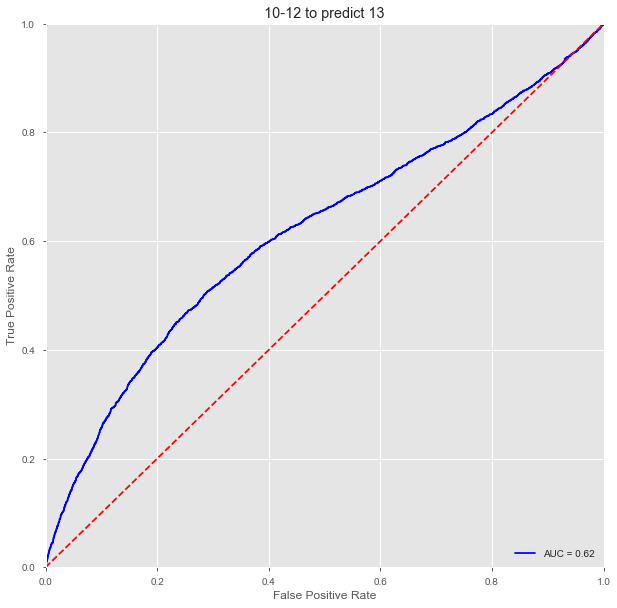

In [98]:

hold_list = []
fy_augmented = []
for index, split in enumerate([splits_to_try[2]]):
    
    hold_dict = {}
    
    X_train = pd.concat([pd.DataFrame(x) for x in woe_pca_df_list[split[0][0]:split[0][1]]])
    y_train = pd.concat([x['Over Budget'] for x in fy_list[int(split[0][0]):int(split[0][1])]])
    #X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)
    X_test = pd.concat([pd.DataFrame(x) for x in woe_pca_df_list[split[1][0]:split[1][1]]])
    y_test = pd.concat(x['Over Budget'] for x in fy_list[split[1][0]:split[1][1]])
    y_original_budget = pd.concat(x['Original Budget'] for x in fy_list[split[1][0]:split[1][1]])
    #X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

    model = xgb.XGBClassifier() #subsample= 0.8, min_child_weight= 1, max_depth= 4, gamma= 1, colsample_bytree= 1.0)
    model.fit(X_train,y_train)

    xgb_test_predictions = model.predict(X_test)
    xgb_train_predictions = model.predict(X_train)
    
    xgb_test_predictions_probability = [x[1] for x in model.predict_proba(X_test)]
    xgb_train_predictions_probability = [x[1] for x in model.predict_proba(X_train)]

    model_test_auc = metrics.roc_auc_score(y_test, xgb_test_predictions)
    model_train_auc = metrics.roc_auc_score(y_train, xgb_train_predictions)
    original_budget_auc = metrics.roc_auc_score(y_test, y_original_budget)
    
    if index <= 5:
        #hold_df = pd.concat([X_test, y_test]) #grab the test dataframe
        hold_df = pd.concat([x for x in fy_list[split[1][0]:split[1][1]]])
        hold_df['Over_Budget_Prediction'] = xgb_test_predictions_probability #add in the over under budget predictions
        fy_augmented.append(hold_df) #store it back in the woe_pca_df_list
    
    
    hold_dict.update({'split': split[2]})
    hold_dict.update({'model_test_auc': model_test_auc})
    hold_dict.update({'model_train_auc': model_train_auc})
    hold_dict.update({'original_budget_auc': original_budget_auc})
    hold_dict.update({'model':model})
    
    
    
    hold_list.append(hold_dict)
    
fpr, tpr, threshold = metrics.roc_curve(y_test, xgb_test_predictions_probability)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.title(split[2])
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
    

In [99]:
pd.DataFrame(hold_list).drop(['model'],axis=1)

,model_test_auc,model_train_auc,original_budget_auc,split
0,0.593855,0.671056,0.458223,10-12 to predict 13


In [100]:
confusion_df = pd.DataFrame(metrics.confusion_matrix(y_test, xgb_test_predictions))
confusion_df.columns=["", ""]
confusion_df.index =["",""]
confusion_df

,,
,6382,1120
,2650,1347


In [101]:
confusion_matrix_key = confusion_df
confusion_matrix_key.iloc[0,0] = 'True Negatives'
confusion_matrix_key.iloc[1,0] = 'False Negative'
confusion_matrix_key.iloc[1,1] = 'True Positives'
confusion_matrix_key.iloc[0,1] = 'False Positives'
confusion_matrix_key.columns= ["",""]
confusion_matrix_key.index =["",""]
confusion_matrix_key


,,
,True Negatives,False Positives
,False Negative,True Positives


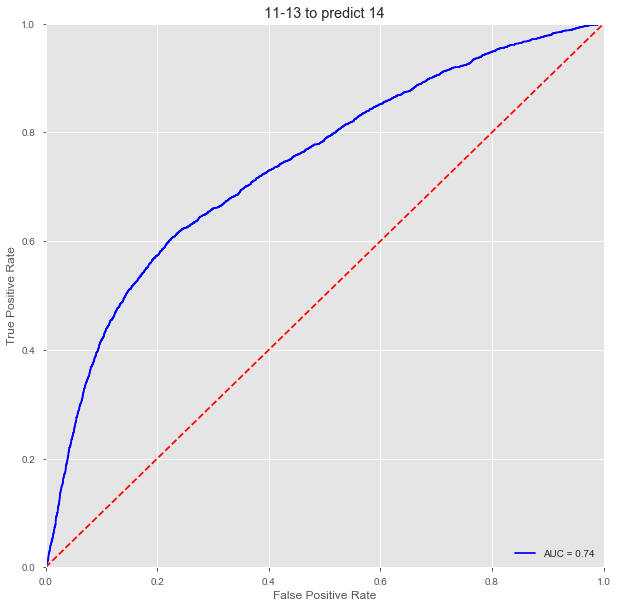

In [102]:

hold_list = []
fy_augmented = []
for index, split in enumerate([splits_to_try[3]]):
    
    hold_dict = {}
    
    X_train = pd.concat([pd.DataFrame(x) for x in woe_pca_df_list[split[0][0]:split[0][1]]])
    y_train = pd.concat([x['Over Budget'] for x in fy_list[int(split[0][0]):int(split[0][1])]])
    #X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)
    X_test = pd.concat([pd.DataFrame(x) for x in woe_pca_df_list[split[1][0]:split[1][1]]])
    y_test = pd.concat(x['Over Budget'] for x in fy_list[split[1][0]:split[1][1]])
    y_original_budget = pd.concat(x['Original Budget'] for x in fy_list[split[1][0]:split[1][1]])
    #X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

    model = xgb.XGBClassifier() #subsample= 0.8, min_child_weight= 1, max_depth= 4, gamma= 1, colsample_bytree= 1.0)
    model.fit(X_train,y_train)

    xgb_test_predictions = model.predict(X_test)
    xgb_train_predictions = model.predict(X_train)
    
    xgb_test_predictions_probability = [x[1] for x in model.predict_proba(X_test)]
    xgb_train_predictions_probability = [x[1] for x in model.predict_proba(X_train)]

    model_test_auc = metrics.roc_auc_score(y_test, xgb_test_predictions)
    model_train_auc = metrics.roc_auc_score(y_train, xgb_train_predictions)
    original_budget_auc = metrics.roc_auc_score(y_test, y_original_budget)
    
    if index <= 5:
        #hold_df = pd.concat([X_test, y_test]) #grab the test dataframe
        hold_df = pd.concat([x for x in fy_list[split[1][0]:split[1][1]]])
        hold_df['Over_Budget_Prediction'] = xgb_test_predictions_probability #add in the over under budget predictions
        fy_augmented.append(hold_df) #store it back in the woe_pca_df_list
    
    
    hold_dict.update({'split': split[2]})
    hold_dict.update({'model_test_auc': model_test_auc})
    hold_dict.update({'model_train_auc': model_train_auc})
    hold_dict.update({'original_budget_auc': original_budget_auc})
    hold_dict.update({'model':model})
    
    
    
    hold_list.append(hold_dict)
    
fpr, tpr, threshold = metrics.roc_curve(y_test, xgb_test_predictions_probability)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.title(split[2])
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
    

In [103]:
pd.DataFrame(hold_list).drop(['model'],axis=1)

,model_test_auc,model_train_auc,original_budget_auc,split
0,0.682113,0.681035,0.462134,11-13 to predict 14


In [104]:
confusion_df = pd.DataFrame(metrics.confusion_matrix(y_test, xgb_test_predictions))
confusion_df.columns=["", ""]
confusion_df.index =["",""]
confusion_df

,,
,6380,1269
,1809,2041


In [105]:
confusion_matrix_key = confusion_df
confusion_matrix_key.iloc[0,0] = 'True Negatives'
confusion_matrix_key.iloc[1,0] = 'False Negative'
confusion_matrix_key.iloc[1,1] = 'True Positives'
confusion_matrix_key.iloc[0,1] = 'False Positives'
confusion_matrix_key.columns= ["",""]
confusion_matrix_key.index =["",""]
confusion_matrix_key


,,
,True Negatives,False Positives
,False Negative,True Positives


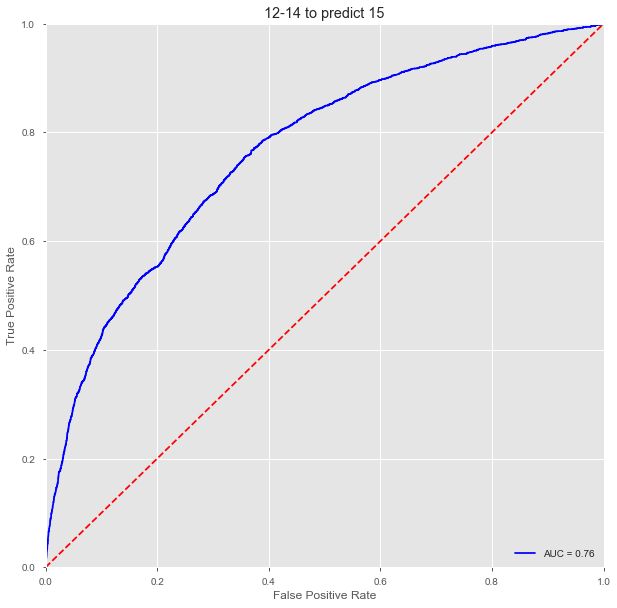

In [106]:

hold_list = []
fy_augmented = []
for index, split in enumerate([splits_to_try[4]]):
    
    hold_dict = {}
    
    X_train = pd.concat([pd.DataFrame(x) for x in woe_pca_df_list[split[0][0]:split[0][1]]])
    y_train = pd.concat([x['Over Budget'] for x in fy_list[int(split[0][0]):int(split[0][1])]])
    #X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)
    X_test = pd.concat([pd.DataFrame(x) for x in woe_pca_df_list[split[1][0]:split[1][1]]])
    y_test = pd.concat(x['Over Budget'] for x in fy_list[split[1][0]:split[1][1]])
    y_original_budget = pd.concat(x['Original Budget'] for x in fy_list[split[1][0]:split[1][1]])
    #X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

    model = xgb.XGBClassifier() #subsample= 0.8, min_child_weight= 1, max_depth= 4, gamma= 1, colsample_bytree= 1.0)
    model.fit(X_train,y_train)

    xgb_test_predictions = model.predict(X_test)
    xgb_train_predictions = model.predict(X_train)
    
    xgb_test_predictions_probability = [x[1] for x in model.predict_proba(X_test)]
    xgb_train_predictions_probability = [x[1] for x in model.predict_proba(X_train)]

    model_test_auc = metrics.roc_auc_score(y_test, xgb_test_predictions)
    model_train_auc = metrics.roc_auc_score(y_train, xgb_train_predictions)
    original_budget_auc = metrics.roc_auc_score(y_test, y_original_budget)
    
    if index <= 5:
        #hold_df = pd.concat([X_test, y_test]) #grab the test dataframe
        hold_df = pd.concat([x for x in fy_list[split[1][0]:split[1][1]]])
        hold_df['Over_Budget_Prediction'] = xgb_test_predictions_probability #add in the over under budget predictions
        fy_augmented.append(hold_df) #store it back in the woe_pca_df_list
    
    
    hold_dict.update({'split': split[2]})
    hold_dict.update({'model_test_auc': model_test_auc})
    hold_dict.update({'model_train_auc': model_train_auc})
    hold_dict.update({'original_budget_auc': original_budget_auc})
    hold_dict.update({'model':model})
    
    
    
    hold_list.append(hold_dict)
    
fpr, tpr, threshold = metrics.roc_curve(y_test, xgb_test_predictions_probability)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.title(split[2])
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
    

In [107]:
pd.DataFrame(hold_list).drop(['model'],axis=1)

,model_test_auc,model_train_auc,original_budget_auc,split
0,0.680139,0.705269,0.429731,12-14 to predict 15


In [108]:
confusion_df = pd.DataFrame(metrics.confusion_matrix(y_test, xgb_test_predictions))
confusion_df.columns=["", ""]
confusion_df.index =["",""]
confusion_df

,,
,6117,1346
,1854,2182


In [109]:
confusion_matrix_key = confusion_df
confusion_matrix_key.iloc[0,0] = 'True Negatives'
confusion_matrix_key.iloc[1,0] = 'False Negative'
confusion_matrix_key.iloc[1,1] = 'True Positives'
confusion_matrix_key.iloc[0,1] = 'False Positives'
confusion_matrix_key.columns= ["",""]
confusion_matrix_key.index =["",""]
confusion_matrix_key


,,
,True Negatives,False Positives
,False Negative,True Positives


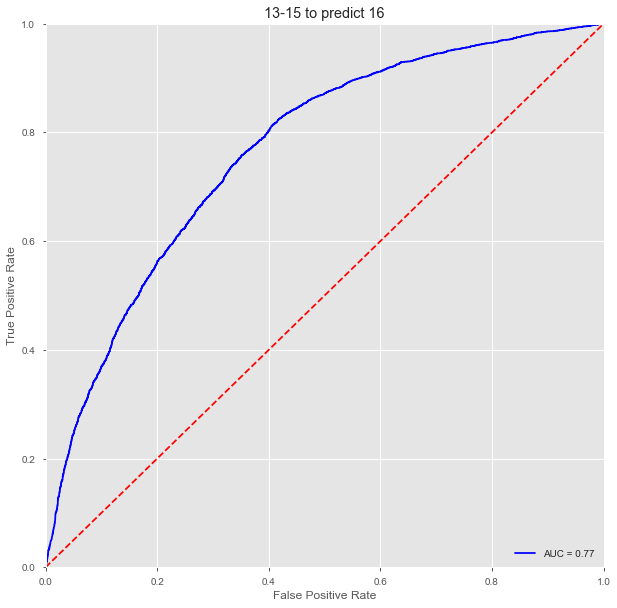

In [110]:

hold_list = []
fy_augmented = []
for index, split in enumerate([splits_to_try[5]]):
    
    hold_dict = {}
    
    X_train = pd.concat([pd.DataFrame(x) for x in woe_pca_df_list[split[0][0]:split[0][1]]])
    y_train = pd.concat([x['Over Budget'] for x in fy_list[int(split[0][0]):int(split[0][1])]])
    #X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)
    X_test = pd.concat([pd.DataFrame(x) for x in woe_pca_df_list[split[1][0]:split[1][1]]])
    y_test = pd.concat(x['Over Budget'] for x in fy_list[split[1][0]:split[1][1]])
    y_original_budget = pd.concat(x['Original Budget'] for x in fy_list[split[1][0]:split[1][1]])
    #X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

    model = xgb.XGBClassifier() #subsample= 0.8, min_child_weight= 1, max_depth= 4, gamma= 1, colsample_bytree= 1.0)
    model.fit(X_train,y_train)

    xgb_test_predictions = model.predict(X_test)
    xgb_train_predictions = model.predict(X_train)
    
    xgb_test_predictions_probability = [x[1] for x in model.predict_proba(X_test)]
    xgb_train_predictions_probability = [x[1] for x in model.predict_proba(X_train)]

    model_test_auc = metrics.roc_auc_score(y_test, xgb_test_predictions)
    model_train_auc = metrics.roc_auc_score(y_train, xgb_train_predictions)
    original_budget_auc = metrics.roc_auc_score(y_test, y_original_budget)
    
    if index <= 5:
        #hold_df = pd.concat([X_test, y_test]) #grab the test dataframe
        hold_df = pd.concat([x for x in fy_list[split[1][0]:split[1][1]]])
        hold_df['Over_Budget_Prediction'] = xgb_test_predictions_probability #add in the over under budget predictions
        fy_augmented.append(hold_df) #store it back in the woe_pca_df_list
    
    
    hold_dict.update({'split': split[2]})
    hold_dict.update({'model_test_auc': model_test_auc})
    hold_dict.update({'model_train_auc': model_train_auc})
    hold_dict.update({'original_budget_auc': original_budget_auc})
    hold_dict.update({'model':model})
    
    
    
    hold_list.append(hold_dict)
    
fpr, tpr, threshold = metrics.roc_curve(y_test, xgb_test_predictions_probability)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.title(split[2])
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
    

In [111]:
pd.DataFrame(hold_list).drop(['model'],axis=1)

,model_test_auc,model_train_auc,original_budget_auc,split
0,0.646545,0.706782,0.464239,13-15 to predict 16


In [112]:
confusion_df = pd.DataFrame(metrics.confusion_matrix(y_test, xgb_test_predictions))
confusion_df.columns=["", ""]
confusion_df.index =["",""]
confusion_df

,,
,6684,899
,2304,1612


In [119]:
confusion_matrix_key = confusion_df
confusion_matrix_key.iloc[0,0] = 'True Negatives'
confusion_matrix_key.iloc[1,0] = 'False Negative'
confusion_matrix_key.iloc[1,1] = 'True Positives'
confusion_matrix_key.iloc[0,1] = 'False Positives'
confusion_matrix_key.columns= ["Confusion Matrix Values Key",""]
confusion_matrix_key.index =["",""]
confusion_matrix_key


,Confusion Matrix Values Key,
,True Negatives,False Positives
,False Negative,True Positives


In [114]:
# del hold_list
# gc.collect()

In [115]:
for i, y in enumerate(fy_list):
    if i ==0:
        None
    else:
        fy_list[i]=fy_augmented[i-1]

IndexError: list index out of range

In [ ]:
for i, y in enumerate(fy_list):
    fy_list[i].to_csv('201'+str(i)+"_clfpred")

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_test, xgb_test_predictions_probability)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.title('AUC 13-15 to Predict 16')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()





In [ ]:
plt.figure(figsize=(10,10))
fpr, tpr, threshold = metrics.roc_curve(y_test, xgb_test_predictions_probability)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.title('AUC 13-15 to Predict 16')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [ ]:
confusion_df = pd.DataFrame(metrics.confusion_matrix(y_test, xgb_test_predictions))
confusion_df.columns=["", ""]
confusion_df.index =["",""]
confusion_df

In [ ]:
confusion_matrix_key = confusion_df
confusion_matrix_key.iloc[0,0] = 'True Negatives'
confusion_matrix_key.iloc[1,0] = 'False Negative'
confusion_matrix_key.iloc[1,1] = 'True Positives'
confusion_matrix_key.iloc[0,1] = 'False Positives'
confusion_matrix_key.columns= ["",""]
confusion_matrix_key.index =["",""]
confusion_matrix_key


# Classifier Prediction has now been added to original dataframe, now predict Actuals using XGB Regressor

In [ ]:
splits_to_try = [
    
                #predicting off "two years"
                 #[(0,1),(1,2),'10-11 to predict 11'],
                 #[(0,2),(2,3),'10-11 to predict 12'],
                 #[(0,3),(3,4),'10-12 to predict 13'],
                 #[(0,3),(3,5),'10-12 to predict 13 and 14'],
                 #[(2,4),(4,5),'12-13 to predict 14'],
                 #[(1,4),(4,5),'11-13 to predict 14'], 
                 #[(1,4),(4,6),'11-13 to predict 14 and 15'],
                 #[(3,5),(5,6),'13-14 to predict 15'],
                 [(2,5),(5,6),'12-14 to predict 15'],
                 #[(2,5),(5,7),'12-14 to predict 15 and 16'],
                 #[(4,6),(6,7),'14-15 to predict 16'],
                 #[(3,6),(6,7),'13-15 to predict 16'], 
    
                #predicting off "three" years
    
                 #[(0,4),(5,6),'10-13 to predict 14'],
                 #[(0,4),(4,6),'10-13 to predict 14 and 15'],
                 #[(0,4),(4,7),'10-13 to predict 14 and 15 and 16'],
                 #[(1,5),(5,6),'11-14 to predict 15'],
                 #[(1,5),(5,7),'11-14 to predict 15 and 16'],
                 #[(2,6),(6,7),'12-15 to predict 16']
                ]

In [ ]:
hold_list = []
weight_df_list = []
for split in splits_to_try:
    
    hold_dict = {}
    
    X_train = pd.concat([x for x in fy_list[split[0][0]:split[0][1]]])
    y_train = X_train['Actuals']
    X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)
    X_test = pd.concat([x for x in fy_list[split[1][0]:split[1][1]]])
    y_test = X_test['Actuals']
    y_original_budget = X_test['Original Budget']
    X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

    model = xgb.XGBRegressor(subsample= 0.8, min_child_weight= 1, max_depth= 4, gamma= 1, seed=1001, colsample_bytree= 1.0)
    model.fit(X_train,y_train)

    xgb_test_predictions = model.predict(X_test)
    xgb_train_predictions = model.predict(X_train)

    model_test_RMSE = np.sqrt(np.mean((xgb_test_predictions-y_test)**2))
    model_train_RMSE = np.sqrt(np.mean((xgb_train_predictions-y_train)**2))
    original_budget_RMSE = np.sqrt(np.mean((y_original_budget-y_test)**2))
    
    weight_dict = model.get_booster().get_score(importance_type="weight")
    weight_df = pd.DataFrame(weight_dict, index=range(len(weight_dict)))
    weight_df = weight_df.T[0].sort_values(ascending=False)
    
    weight_df_list.append(weight_df)

    hold_dict.update({'split': split[2]})
    hold_dict.update({'model_test_RMSE': model_test_RMSE})
    hold_dict.update({'model_train_RMSE': model_train_RMSE})
    hold_dict.update({'original_budget_RMSE': original_budget_RMSE})
    hold_dict.update({'test_predictions': xgb_test_predictions})
    hold_dict.update({'train_predictions' : xgb_train_predictions})
    hold_dict.update({'y_test' : y_test})
    hold_dict.update({'y_train' : y_train})
    hold_dict.update({'original_budget' : y_original_budget})
    hold_list.append(hold_dict)
    
   
results_df = pd.DataFrame(hold_list)
results_df['Model Improvement'] = results_df['original_budget_RMSE']-results_df['model_test_RMSE']
results_df



In [ ]:
del hold_list
gc.collect()

In [ ]:

# y_train = downsample(y_train, int(len(y_train)/2))
# y_test = downsample(y_test, int(len(y_test)/2))
# xgb_test_predictions = downsample(xgb_test_predictions, int(len(xgb_test_predictions)/2))
# xgb_train_predictions = downsample(xgb_train_predictions, int(len(xgb_train_predictions)/2))
# y_original_budget = downsample(y_original_budget.values, int(len(y_original_budget.values)/2))
# split = results_df.iloc[0]['split']



In [ ]:
# df_1214_15_train = pd.DataFrame()
# df_1214_15_test = pd.DataFrame()

In [ ]:
# df_1214_15_train['y_train'] = y_train
# df_1214_15_test['y_test'] = y_test
# df_1214_15_test['xgb_test_predictions'] = xgb_test_predictions
# df_1214_15_train['xgb_train_predictions'] = xgb_train_predictions
# df_1214_15_test['original_budget'] = y_original_budget


In [ ]:
y_original_budget[0][:10]

In [ ]:
y_test[:10].values

In [ ]:
# fig, ax = plt.subplots(nrows=2,ncols=3)
# fig.set_size_inches(16,12)
sns.set_style('whitegrid')

x = np.linspace(-1000000000,1000000000,1000000000)
plt.figure(figsize=(12,12))
plt.scatter(y_train, xgb_train_predictions, c='red') #alpha=.95)
plt.scatter(y_test, xgb_test_predictions, c='blue') #alpha=.95)
plt.scatter(y_test, y_original_budget, c='green') #alpha=.95)
plt.plot(x,x,c='black')
plt.xlim([-5,1000000000])
plt.ylim([-5,1000000000])
plt.xlabel('observations')
plt.ylabel('predictions')
plt.title(split)


fig.tight_layout()

In [ ]:
#results_df.iloc[:,0:5].drop(['original_budget'],axis=1).to_csv("results_df.csv")

In [ ]:

#downsampled =  signal.resample(y, 6000)

In [ ]:
# for index, row in results_df.iterrows():
#     xgb_test_predictions = row['test_predictions']
#     y_test = row['y_test']
#     y_original_budget = row['original_budget']
#     results_df.loc[index, 'Model Sum Error'] = int(np.sum(abs(xgb_test_predictions-y_test)))
#     results_df.loc[index, 'Budget Sum Error'] = int(np.sum(abs(y_original_budget-y_test)))
#     results_df.loc[index, 'Model Increased Precision'] = int(results_df.loc[index, 'Budget Sum Error']-results_df.loc[index, 'Model Sum Error'])
    
    

In [ ]:
results_df

In [ ]:
from scipy.interpolate import interp1d

def downsample(array, npts):
    interpolated = interp1d(np.arange(len(array)), array, axis = 0, fill_value = 'extrapolate')
    downsampled = interpolated(np.linspace(0, len(array), npts))
    return downsampled

#https://stackoverflow.com/questions/53307107/how-do-i-downsample-a-1d-numpy-array

In [ ]:
for item in fy_list[0]

In [125]:
fy_list[0][essentials].rename({"Unnamed: 0":"Line Item"}).head()

,Unnamed: 0,Fund Id,Business Area,Fund Center Id,GL Account,GL Description,GL Category,GL Category Description,Revenue or Expenditure,Fiscal Year,Fund Name,Fund Type Descr,Business Area Name,Fund Center Name,Commitment Set Description,Original Budget,Current Budget,Actuals,3Y_Past_Actuals,2Y_Past_Actuals,1Y_Past_Actuals,2Y_1Y_Actuals_Mean,3Y_2Y_1Y_Actuals_Mean,3Y_Past_Original_Budget,2Y_Past_Original_Budget,1Y_Past_Original_Budget,2Y_1Y_Original_Budget_Mean,3Y_2Y_1Y_Original_Budget_Mean,3Y_Past_OA_Difference,2Y_Past_OA_Difference,1Y_Past_OA_Difference,2Y_1Y_OA_Difference_Mean,3Y_2Y_1Y_OA_Difference_Mean,OA_Difference,Yearly Crime Index,Yearly Avg High Temp,Yearly Avg Low Temp,Yearly Rain Fall,Astros Playoff Rounds,Astros Yearly Attendance,Rockets Playoff Rounds,Texans Playoff Rounds,Texans Average Attendance,Rockets Total Attendance
0,0,1000,3800,3800050001,501070,501070 - Pension - Civilian,500,500 - Personnel Services,Expenditures,2010,General Fund,General Funds,Health & Human Services,HHS-Office Prog Supp,50 - Total Expenditures,113579.0,113579.0,121344.82,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,7765.82,596.6,80.0,62.0,47.01,0.0,2521076.0,0.0,0.0,71080.0,699280.0
1,1,1000,3800,3800020009,511085,511085 - Drugs & Medical Chemicals,510,510 - Supplies,Expenditures,2010,General Fund,General Funds,Health & Human Services,HHS-Department Wide,50 - Total Expenditures,25000.0,25000.0,0.00,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,-25000.00,596.6,80.0,62.0,47.01,0.0,2521076.0,0.0,0.0,71080.0,699280.0
2,2,1000,1000,1000010070,520765,520765 - Membership & Professional Fees,520,520 - Other Services and Charges,Expenditures,2010,General Fund,General Funds,Houston Police Department,HPD-Tactical Ops.,50 - Total Expenditures,140.0,140.0,813.00,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,673.00,596.6,80.0,62.0,47.01,0.0,2521076.0,0.0,0.0,71080.0,699280.0
3,3,1000,3600,3600090002,500010,500010 - Salary Base Pay - Civilian,500,500 - Personnel Services,Expenditures,2010,General Fund,General Funds,Parks & Recreation,PRD-Park Fac. Permit,50 - Total Expenditures,159241.0,161056.0,164955.57,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,5714.57,596.6,80.0,62.0,47.01,0.0,2521076.0,0.0,0.0,71080.0,699280.0
4,4,1000,2100,2100090003,500010,500010 - Salary Base Pay - Civilian,500,500 - Personnel Services,Expenditures,2010,General Fund,General Funds,Solid Waste Management,SWM-SW Yard Waste,50 - Total Expenditures,512310.0,519021.0,454980.25,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,-57329.75,596.6,80.0,62.0,47.01,0.0,2521076.0,0.0,0.0,71080.0,699280.0


In [ ]:
index=0
hold_df1214_15_test = pd.DataFrame()
hold_df1214_15_train = pd.DataFrame()
hold_df1214_15_test['test_predictions'] = results_df.iloc[index]['test_predictions']
hold_df1214_15_train['train_predictions'] = results_df.iloc[index]['test_predictions']
hold_df1214_15_test['y_test'] = results_df.iloc[index]['y_test'].values
hold_df1214_15_train['y_train'] = results_df.iloc[index]['y_train'].values
hold_df1214_15_test['original_budget'] = results_df.iloc[index]['original_budget'].values


In [ ]:
index=1
hold_df1315_17 = pd.DataFrame()
hold_df1315_17['test_predictions'] = results_df.iloc[index]['test_predictions']
hold_df1315_17['train_predictions'] = results_df.iloc[index]['test_predictions']
hold_df1315_17['y_test'] = results_df.iloc[index]['y_test']
hold_df1315_17['y_train'] = results_df.iloc[index]['y_train']
hold_df1315_17['original_budget'] = results_df.iloc[index]['original_budget']


In [ ]:
# fig, ax = plt.subplots(nrows=2,ncols=3)
# fig.set_size_inches(16,12)
# sns.set_style('whitegrid')
# i = 0

# for index, row in results_df.iterrows():
#     y_train = downsample(row['y_train'], int(len(row['y_train'])/5))
#     y_test = downsample(row['y_test'], int(len(row['y_test'])/5))
#     xgb_test_predictions = downsample(row['test_predictions'], int(len(row['test_predictions'])/5))
#     xgb_train_predictions = downsample(row['train_predictions'], int(len(row['train_predictions'])/5))
#     y_original_budget = downsample(row['original_budget'], int(len(row['original_budget'])/5))
#     split = row['split']
    
#     x = np.linspace(-1000000000,1000000000,1000000000)
#     plt.figure(figsize=(12,12))
#     plt.scatter(y_train, xgb_train_predictions, c='red') #alpha=.95)
#     plt.scatter(y_test, xgb_test_predictions, c='blue') #alpha=.95)
#     plt.scatter(y_test, y_original_budget, c='green') #alpha=.95)
#     plt.plot(x,x,c='black')
#     plt.xlim([-5,1000000000])
#     plt.ylim([-5,1000000000])
#     plt.xlabel('observations')
#     plt.ylabel('predictions')
#     plt.title(split)


# fig.tight_layout()